In [155]:
!pip install deap
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
# вычисление степени "2" целого числа
def power_of_two(n):
  sqr = 1
  r = 0
  while(sqr <= n):
    #print(r,' ', sqr,' ')
    sqr = sqr * 2
    r += 1
  return(r)

In [157]:
# вычисление необходимой длины особи с учетом области определения и области значения
def MAX_LENGTH(low, up, eps):
  N = (up - low) / eps
  return power_of_two(N)

In [158]:
# константы задачи
BOUND_LOW, BOUND_UP = -10.0, 10.0 # границы
EPS = 0.001 # точность
ONE_MAX_LENGTH = MAX_LENGTH(BOUND_LOW, BOUND_UP, EPS)
FX_MIN = -10.6660

In [159]:
round(-10.6659783, 3)

-10.666

In [160]:
# исследуемые параметры
IND_COUNTS = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70, 75, 80, 85, 90, 95, 100]
P_CROSSOVERS = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
P_MUTATES = [x * 0.01 for x in range(1, 11)]
print(P_MUTATES)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


In [161]:
# константы ГА
POPULATION_SIZE = 250 # количество индивидуумов в популяции
P_CROSSOVER = 0.9 # вероятность скрещивания
P_MUTATION = 0.071 # вероятность мутации индивидуума
MAX_GENERATIONS = 2000 # максимальное количество поколений
HALL_OF_FAME_SIZE = 10 # Зал славы

In [162]:
# задаем зерно генерации для отслеживания 
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [163]:
toolbox = base.Toolbox()
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [164]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [165]:
toolbox.register("IndividualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGTH)
toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.IndividualCreator)

In [166]:
def f(x):
  return (x - 1.0) * np.cos(3 * x - 15.0)

In [167]:
# функция приспособленности
def FF(individual, low, up, eps):
  x = int(re.sub(r"[\[\]\,\s]", "", str(individual)), 2)
  h = (up - low)/(2 ** ONE_MAX_LENGTH - 1)
  x1 = low + x * h
  return f(x1),

In [168]:
toolbox.register("evaluate", FF, low=BOUND_LOW, up=BOUND_UP, eps=EPS)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ONE_MAX_LENGTH)

In [184]:
def eaSimpleAimToMin(population, toolbox, minval=0.0, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS, eps=EPS):
  logbook = tools.Logbook()
  generation_counter = 0

  fitness_values = list(map(toolbox.evaluate, population))
  for individual, fitnessValue in zip(population, fitness_values):
    individual.fitness.values = fitnessValue
  fitness_values = [individual.fitness.values[0] for individual in population]
  logbook.record(gen=generation_counter, min=np.min(fitness_values), abs_eps=abs(FX_MIN) - abs(np.min(fitness_values)))
  
  while generation_counter < MAX_GENERATIONS and not round(np.min(fitness_values), 3) == minval:
    generation_counter = generation_counter + 1
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < cxpb:
        toolbox.mate(child1, child2)
        del child1.fitness.values
        del child2.fitness.values
    
    for mutant in offspring:
      if random.random() < mutpb:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    
    fresh_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fresh_fitness_values = list(map(toolbox.evaluate, fresh_individuals))
    for individual, fitnessValue in zip(fresh_individuals, fresh_fitness_values):
      individual.fitness.values = fitnessValue
    
    population[:] = offspring

    fitness_values = [ind.fitness.values[0] for ind in population]
    min_fitness = np.min(fitness_values)
    avg_fitness = sum(fitness_values) / len(population)

    #print("- Поколение {}: Мин приспособ. = {}, Средняя приспособ. = {}, eps = {}".format(generation_counter, min_fitness, avg_fitness, int(np.min(fitness_values) *  (1/eps)) /  (1/eps)))

    logbook.record(gen=generation_counter, min=min_fitness, abs_eps=abs(FX_MIN) - abs(min_fitness))

  return population, logbook

In [173]:
def GA(crossover=P_CROSSOVER, mutate=P_MUTATION, pop_size=POPULATION_SIZE):
  # задаем зерно генерации для отслеживания 
  RANDOM_SEED = 28
  random.seed(RANDOM_SEED)

  # создаем популяцию
  population = toolbox.PopulationCreator(n=pop_size)

  #stats = tools.Statistics(lambda ind: ind.fitness.values)
  #stats.register("min", np.min)
  #stats.register("abs_eps", lambda val: abs(FX_MIN) - abs(val))

  population, logbook = eaSimpleAimToMin(population, toolbox, cxpb=crossover, mutpb=mutate, ngen=MAX_GENERATIONS, minval=FX_MIN)
  #population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover, mutpb=mutate, ngen=MAX_GENERATIONS, stats=stats, verbose=False)
  return logbook

5 [1.0499220633278892, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 0.8297787943276838, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.5171468093456575, 1.517146809345657

KeyboardInterrupt: ignored

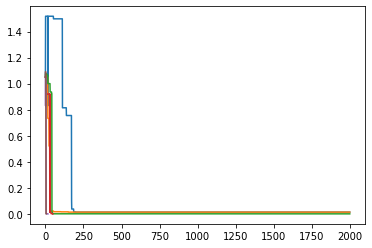

In [185]:
log = [];
_, ax = plt.subplots()

for count in IND_COUNTS:
  logbook = GA(pop_size=count)
  min, abs_eps = logbook.select("min", "abs_eps")
  print(count, abs_eps)
  ax.plot(abs_eps, label=count)

plt.show()

0.3 223
0.35 223
0.4 223
0.45 223
0.5 223
0.55 223


KeyboardInterrupt: ignored

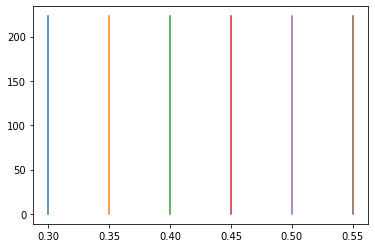

In [171]:
log = [];
_, ax = plt.subplots()

for p in P_CROSSOVERS:
  logbook = GA(pop_size=75, crossover=p)
  gen, min = logbook.select("gen", "min")
  p = [p] * len(gen)
  ax.plot(p, gen)
  print(p[0], gen[-1])

plt.show()

In [ ]:
log = [];
_, ax = plt.subplots()

for p in P_MUTATES:
  logbook = GA(pop_size=90, crossover=0.7, mutate=p)
  gen, min = logbook.select("gen", "min")
  p = [p] * len(gen)
  ax.plot(p, gen)
  print(p[0], gen[-1])

plt.show()